# Momento de Retroalimentación

Módulo 2 Implementación de un modelo de deep learning.

Alejandro Domínguez Lugo
A01378028

## Librerías

In [257]:
# Solo si es necesario
# !pip install --ignore-installed --upgrade tensorflow

In [258]:
# Importar librerías necesarias
from google.colab import drive
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

## Dataset

El dataset seleccionado es para clasificación entre osos y pandas. Este fue recuperado de Kaggle: https://www.kaggle.com/datasets/mattop/panda-or-bear-image-classification?select=PandasBears

El objetivo es poder clasificar entre osos y pandas

Primero se monta drive

In [259]:
# Montar en drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Luego se cargan los datos

In [260]:
# Datos para cargar datos
imageSize = 256
batchSize = 32

In [261]:
# Generar paths
pathTrain = "/content/drive/MyDrive/702/MomentoRetroM2/E1/Dataset/Train"
pathTest = "/content/drive/MyDrive/702/MomentoRetroM2/E1/Dataset/Test"
pathValidation = "/content/drive/MyDrive/702/MomentoRetroM2/E1/Dataset/Validation"
pathEvaluation = "/content/drive/MyDrive/702/MomentoRetroM2/E1/Dataset/Evaluation"

In [294]:
# Cargar datos  
train = image_dataset_from_directory(pathTrain, 
                                     image_size=(imageSize, imageSize), 
                                     batch_size = batchSize)
test = image_dataset_from_directory(pathTest, 
                                    image_size=(imageSize, imageSize), 
                                    batch_size = batchSize)
validation = image_dataset_from_directory(pathValidation, 
                                          image_size=(imageSize, imageSize), 
                                          batch_size = batchSize)
evaluation = image_dataset_from_directory(pathEvaluation, 
                                          image_size=(imageSize, imageSize), 
                                          batch_size = 5, shuffle = False)

Found 510 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 20 files belonging to 2 classes.


El set de evaluación es un set recuperado de internet, con imagenes similares y 
considerablemente diferentes al set original. Con fotos reales hasta dibujos que 
se acercan más a lo abstracto.

## Modelos

In [263]:
# Epocas propuestas
epochs = 5

Para el primer modelo se propone una arquitectura simple. Se implementa, primero, un aumento de datos utilizando: *flip*, rotación y *zoom*.
Posteriormente se hace una convolución con un *max pooling*, que se pasa directamente a un *flatten* para posteriormente entrar a una capa con 100 neuronas y finalmente una capa de salida con dos neuronas.

In [264]:
# Modelo 1
model1 = keras.Sequential([
    keras.Input(shape = (256, 256, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255),
    layers.Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (256, 256), 
                  activation = "relu"),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation = "relu"),
    layers.Dense(2, activation = "sigmoid")
])

model1.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_22 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_rotation_22 (RandomR  (None, 256, 256, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_22 (RandomZoom)  (None, 256, 256, 3)      0         
                                                                 
 rescaling_27 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                

In [265]:
# Compilar
model1.compile(optimizer = "sgd", loss = "mean_absolute_error", 
               metrics = ["accuracy"])

# Entrenar
history = model1.fit(train, epochs = epochs, verbose = True, 
                     batch_size = batchSize, validation_data = test)

Epoch 1/5
16/16 [==============================] - 3s 102ms/step - loss: 0.4168 - accuracy: 0.5667 - val_loss: 0.3227 - val_accuracy: 0.7800
Epoch 2/5
16/16 [==============================] - 2s 89ms/step - loss: 0.2386 - accuracy: 0.7725 - val_loss: 0.4314 - val_accuracy: 0.5000
Epoch 3/5
16/16 [==============================] - 2s 92ms/step - loss: 0.1900 - accuracy: 0.8000 - val_loss: 0.1508 - val_accuracy: 0.8000
Epoch 4/5
16/16 [==============================] - 2s 91ms/step - loss: 0.1489 - accuracy: 0.8392 - val_loss: 0.1131 - val_accuracy: 0.8000
Epoch 5/5
16/16 [==============================] - 2s 93ms/step - loss: 0.0746 - accuracy: 0.8961 - val_loss: 0.0932 - val_accuracy: 0.7800


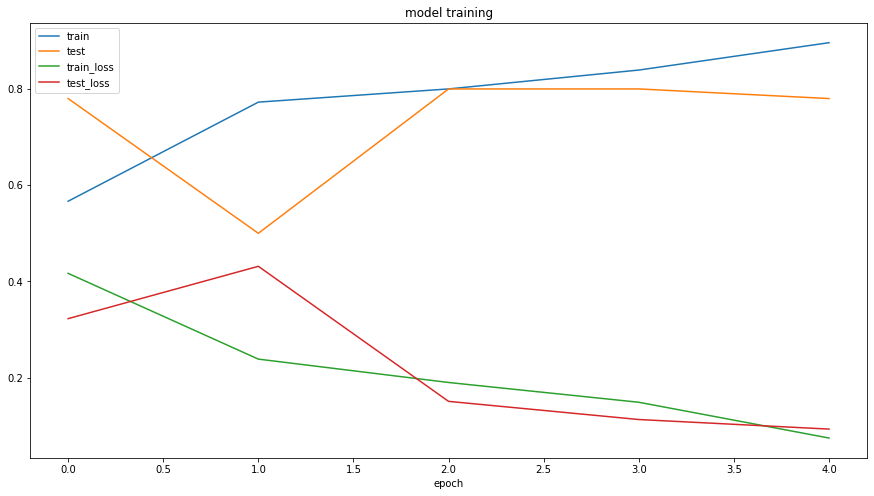

In [266]:
# Mostrar comportamiento de entrenamiento
plt.subplots(1, 1, figsize = (15, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model training')
plt.xlabel('epoch')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'train_loss', 'test_loss'], loc='upper left')
plt.show()

Se puede observar cómo el modelo empieza a aprender de forma correcta hacia la época 5, pero parece ser que se detiene antes de alcanzar un punto estable. Por esta razón, se aumentarán la cantidad de épocas y se implementará un *callback* de *early stop* para detener el entrenamiento cuando se alcanzen los resultados deseados.

In [267]:
epochs = 25

In [268]:
# Callback propuesto
earlyStop = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)

In [269]:
# Reentrenar modelo 1
history = model1.fit(train, epochs = epochs, verbose = True, 
                     batch_size = batchSize, validation_data = test, 
                     callbacks = [earlyStop])

Epoch 1/25
16/16 [==============================] - 2s 105ms/step - loss: 0.0472 - accuracy: 0.8667 - val_loss: 0.0604 - val_accuracy: 0.8000
Epoch 2/25
16/16 [==============================] - 2s 89ms/step - loss: 0.0456 - accuracy: 0.8020 - val_loss: 0.0749 - val_accuracy: 0.7200
Epoch 3/25
16/16 [==============================] - 3s 130ms/step - loss: 0.0325 - accuracy: 0.8137 - val_loss: 0.0469 - val_accuracy: 0.7800
Epoch 4/25
16/16 [==============================] - 2s 100ms/step - loss: 0.0290 - accuracy: 0.8216 - val_loss: 0.0327 - val_accuracy: 0.8600
Epoch 5/25
16/16 [==============================] - 2s 88ms/step - loss: 0.0301 - accuracy: 0.8098 - val_loss: 0.0467 - val_accuracy: 0.7000
Epoch 6/25
16/16 [==============================] - 2s 88ms/step - loss: 0.0281 - accuracy: 0.7902 - val_loss: 0.0458 - val_accuracy: 0.7000
Epoch 7/25
16/16 [==============================] - 2s 90ms/step - loss: 0.0275 - accuracy: 0.7314 - val_loss: 0.0391 - val_accuracy: 0.7000
Epoch 8/25

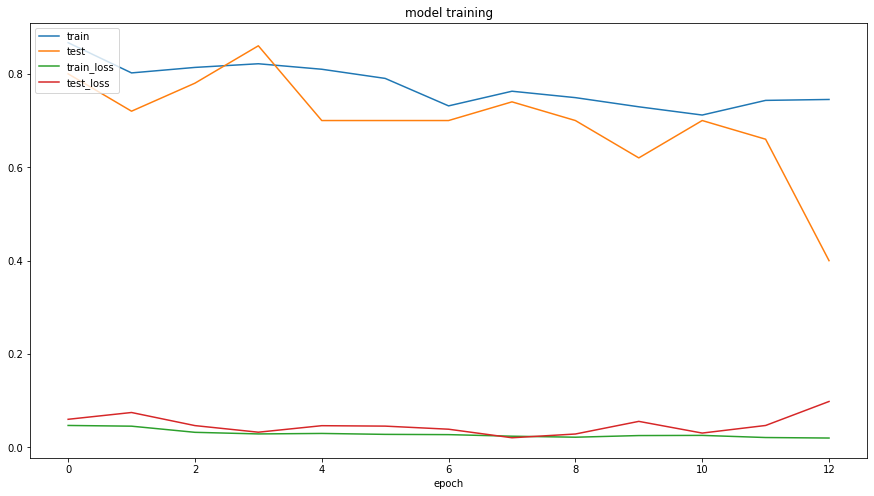

In [270]:
# Mostrar resultados de entrenamiento
plt.subplots(1, 1, figsize = (15, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model training')
plt.xlabel('epoch')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'train_loss', 'test_loss'], loc='upper left')
plt.show()

El modelo se comporta bien, aunque parece tener un *accuracy* mejorable. Por esta razón se buscará aumentar la profundidad del modelo con otra capa de convolución y una más de *max pooling*

In [271]:
# Modelo 2
model2 = keras.Sequential([
    keras.Input(shape = (256, 256, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255),
    layers.Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (256, 256), 
                  activation = "relu"),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation = "relu"),
    layers.Dense(2, activation = "sigmoid")
])

model2.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_23 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_rotation_23 (RandomR  (None, 256, 256, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_23 (RandomZoom)  (None, 256, 256, 3)      0         
                                                                 
 rescaling_28 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_56 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                

In [272]:
# Compilar modelo
model2.compile(optimizer = "sgd", loss = "mean_absolute_error", 
               metrics = ["accuracy"])

# Entrenar
history = model2.fit(train, epochs = epochs, verbose = True, 
                     batch_size = batchSize, validation_data = test, 
                     callbacks = [earlyStop])

Epoch 1/25
16/16 [==============================] - 3s 112ms/step - loss: 0.4771 - accuracy: 0.5118 - val_loss: 0.4506 - val_accuracy: 0.5000
Epoch 2/25
16/16 [==============================] - 2s 97ms/step - loss: 0.3966 - accuracy: 0.5490 - val_loss: 0.3710 - val_accuracy: 0.5800
Epoch 3/25
16/16 [==============================] - 2s 95ms/step - loss: 0.3274 - accuracy: 0.6549 - val_loss: 0.3539 - val_accuracy: 0.6600
Epoch 4/25
16/16 [==============================] - 2s 124ms/step - loss: 0.2511 - accuracy: 0.7510 - val_loss: 0.1559 - val_accuracy: 0.8200
Epoch 5/25
16/16 [==============================] - 2s 101ms/step - loss: 0.1678 - accuracy: 0.7667 - val_loss: 0.1085 - val_accuracy: 0.8800
Epoch 6/25
16/16 [==============================] - 2s 97ms/step - loss: 0.1539 - accuracy: 0.7902 - val_loss: 0.0731 - val_accuracy: 0.8800
Epoch 7/25
16/16 [==============================] - 2s 93ms/step - loss: 0.1384 - accuracy: 0.7314 - val_loss: 0.0759 - val_accuracy: 0.8800
Epoch 8/25

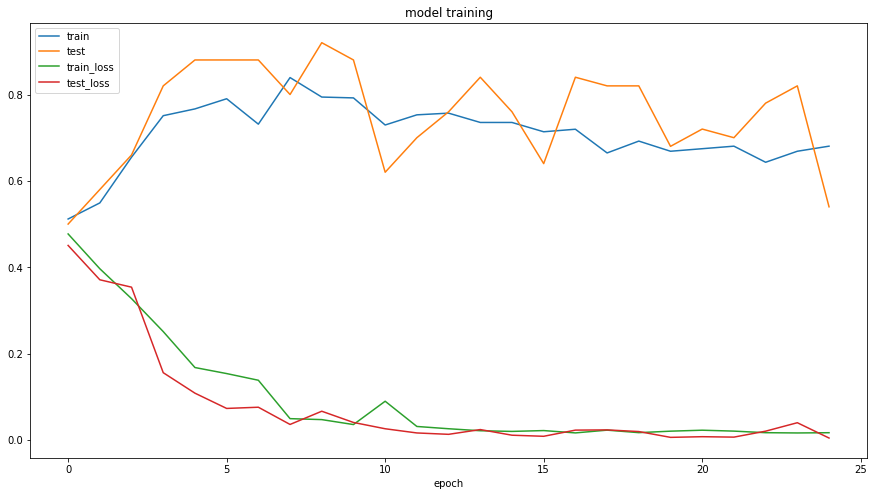

In [273]:
# Mostrar resultados de entrenamiento
plt.subplots(1, 1, figsize = (15, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model training')
plt.xlabel('epoch')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'train_loss', 'test_loss'], loc='upper left')
plt.show()

El desempeño del modelo es considerablemente peor a la arquitectura anterior. Pese a esto, antes de modificar la estructura se buscará mejorar el desempeño cambiando el optimizador de sgd a adam, buscando que haya una menor generalización y que se acerque a una convergencia más rápido.

In [274]:
# Modelo 3
model3 = keras.Sequential([
    keras.Input(shape = (256, 256, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255),
    layers.Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (256, 256), 
                  activation = "relu"),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation = "relu"),
    layers.Dense(2, activation = "sigmoid")
])

model3.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_24 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_rotation_24 (RandomR  (None, 256, 256, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_24 (RandomZoom)  (None, 256, 256, 3)      0         
                                                                 
 rescaling_29 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_58 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                

In [275]:
# Compilar modelo
model3.compile(optimizer = "adam", loss = "mean_absolute_error", 
               metrics = ["accuracy"])

# Entrenar modelo
history = model3.fit(train, epochs = epochs, verbose = True, 
                     batch_size = batchSize, validation_data = test, 
                     callbacks = [earlyStop])

Epoch 1/25
16/16 [==============================] - 3s 112ms/step - loss: 0.5000 - accuracy: 0.5020 - val_loss: 0.5000 - val_accuracy: 0.5200
Epoch 2/25
16/16 [==============================] - 2s 96ms/step - loss: 0.4902 - accuracy: 0.4902 - val_loss: 0.5000 - val_accuracy: 0.6200
Epoch 3/25
16/16 [==============================] - 2s 96ms/step - loss: 0.4902 - accuracy: 0.4941 - val_loss: 0.5000 - val_accuracy: 0.5600
Epoch 4/25
16/16 [==============================] - 2s 96ms/step - loss: 0.4902 - accuracy: 0.5039 - val_loss: 0.5000 - val_accuracy: 0.5600
Epoch 5/25
16/16 [==============================] - 2s 93ms/step - loss: 0.4902 - accuracy: 0.5098 - val_loss: 0.5000 - val_accuracy: 0.5600
Epoch 6/25
16/16 [==============================] - 2s 95ms/step - loss: 0.4902 - accuracy: 0.4941 - val_loss: 0.5000 - val_accuracy: 0.5600


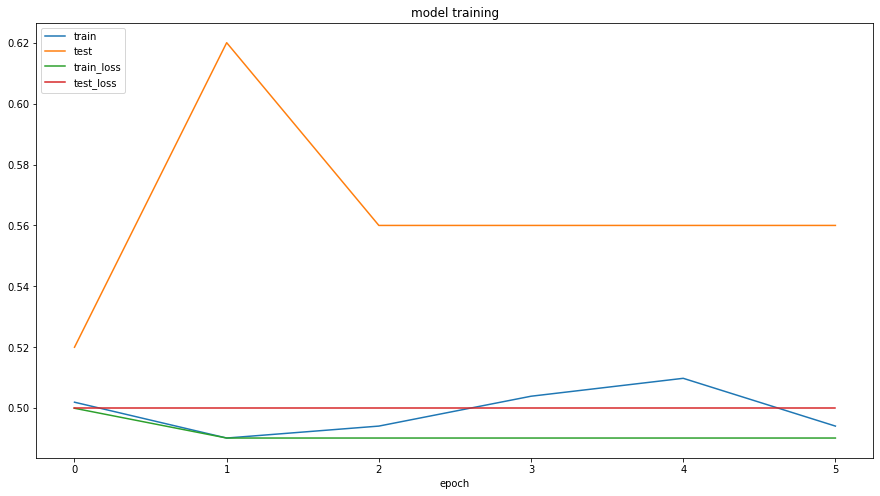

In [276]:
# Mostrar resultado de entrenamiento
plt.subplots(1, 1, figsize = (15, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model training')
plt.xlabel('epoch')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'train_loss', 'test_loss'], loc='upper left')
plt.show()

El modelo dejó de ser caótico aunque para poder mejorar el entrenamiento, además, se cambiará la evaluación de pérdida a "sparce categorical crossentropy". Esto permitirá tener una evaluación más precisa y podría mejorar el modelo.

In [277]:
# Modelo 4
model4 = keras.Sequential([
    keras.Input(shape = (256, 256, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255),
    layers.Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (256, 256), 
                  activation = "relu"),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation = "relu"),
    layers.Dense(2, activation = "sigmoid")
])

model4.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_25 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_rotation_25 (RandomR  (None, 256, 256, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_25 (RandomZoom)  (None, 256, 256, 3)      0         
                                                                 
 rescaling_30 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                

In [278]:
# Compilar modelo
model4.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", 
               metrics = ["accuracy"])

# Entrenar modelo
history = model4.fit(train, epochs = epochs, verbose = True, 
                     batch_size = batchSize, validation_data = test, 
                     callbacks = [earlyStop])

Epoch 1/25
16/16 [==============================] - 3s 113ms/step - loss: 2.7738 - accuracy: 0.6765 - val_loss: 0.4318 - val_accuracy: 0.8400
Epoch 2/25
16/16 [==============================] - 2s 98ms/step - loss: 0.0836 - accuracy: 0.9627 - val_loss: 0.0953 - val_accuracy: 0.9200
Epoch 3/25
16/16 [==============================] - 2s 98ms/step - loss: 0.0341 - accuracy: 0.9882 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 4/25
16/16 [==============================] - 3s 145ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 8.6713e-04 - val_accuracy: 1.0000
Epoch 5/25
16/16 [==============================] - 3s 164ms/step - loss: 0.0089 - accuracy: 0.9961 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 6/25
16/16 [==============================] - 3s 164ms/step - loss: 0.0210 - accuracy: 0.9941 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 7/25
16/16 [==============================] - 2s 113ms/step - loss: 0.0173 - accuracy: 0.9902 - val_loss: 0.0604 - val_accuracy: 0.9600
Epoc

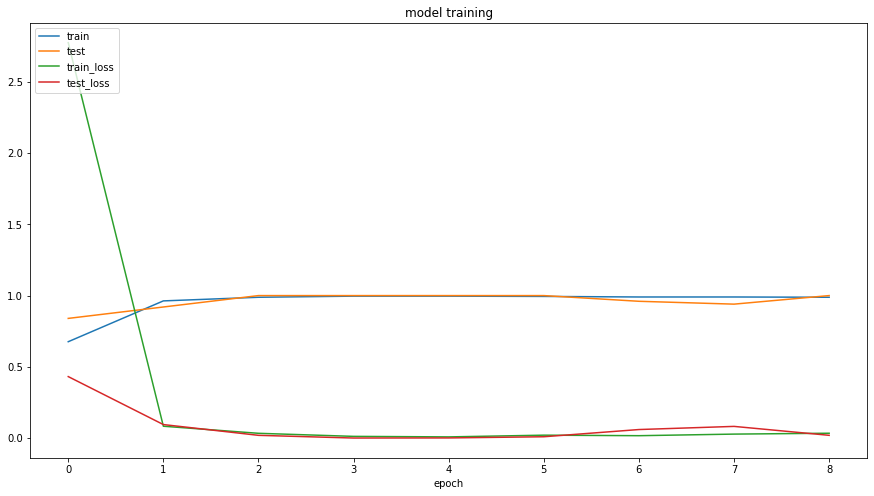

In [279]:
# Mostrar resultados de entrenamiento
plt.subplots(1, 1, figsize = (15, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model training')
plt.xlabel('epoch')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'train_loss', 'test_loss'], loc='upper left')
plt.show()

Se puede observar cómo el modelo mejoró considerablemente.

Se buscará modificar la arquitectura buscando aumentar la profundidad del modelo. Esto con la intención de tener una comparativa y conseguir el mejor modelo posible.

In [280]:
# Modelo 5
model5 = keras.Sequential([
    keras.Input(shape = (256, 256, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255),
    layers.Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (256, 256), 
                  activation = "relu"),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation = "relu"),
    layers.Dense(2, activation = "sigmoid")
])

model5.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_26 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_rotation_26 (RandomR  (None, 256, 256, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_26 (RandomZoom)  (None, 256, 256, 3)      0         
                                                                 
 rescaling_31 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_62 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                

In [281]:
# Compilar modelo
model5.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", 
               metrics = ["accuracy"])

# Entrenar modelo
history = model5.fit(train, epochs = epochs, verbose = True, 
                     batch_size = batchSize, validation_data = test, 
                     callbacks = [earlyStop])

Epoch 1/25
16/16 [==============================] - 3s 107ms/step - loss: 0.5727 - accuracy: 0.6882 - val_loss: 0.1026 - val_accuracy: 1.0000
Epoch 2/25
16/16 [==============================] - 2s 96ms/step - loss: 0.0777 - accuracy: 0.9804 - val_loss: 0.3186 - val_accuracy: 0.8800
Epoch 3/25
16/16 [==============================] - 2s 98ms/step - loss: 0.0581 - accuracy: 0.9824 - val_loss: 7.1692e-04 - val_accuracy: 1.0000
Epoch 4/25
16/16 [==============================] - 2s 97ms/step - loss: 0.0136 - accuracy: 0.9941 - val_loss: 5.1258e-04 - val_accuracy: 1.0000
Epoch 5/25
16/16 [==============================] - 2s 96ms/step - loss: 0.0166 - accuracy: 0.9922 - val_loss: 2.6745e-04 - val_accuracy: 1.0000
Epoch 6/25
16/16 [==============================] - 2s 96ms/step - loss: 0.0095 - accuracy: 0.9961 - val_loss: 7.1632e-04 - val_accuracy: 1.0000
Epoch 7/25
16/16 [==============================] - 2s 96ms/step - loss: 0.0152 - accuracy: 0.9961 - val_loss: 1.2609e-04 - val_accuracy:

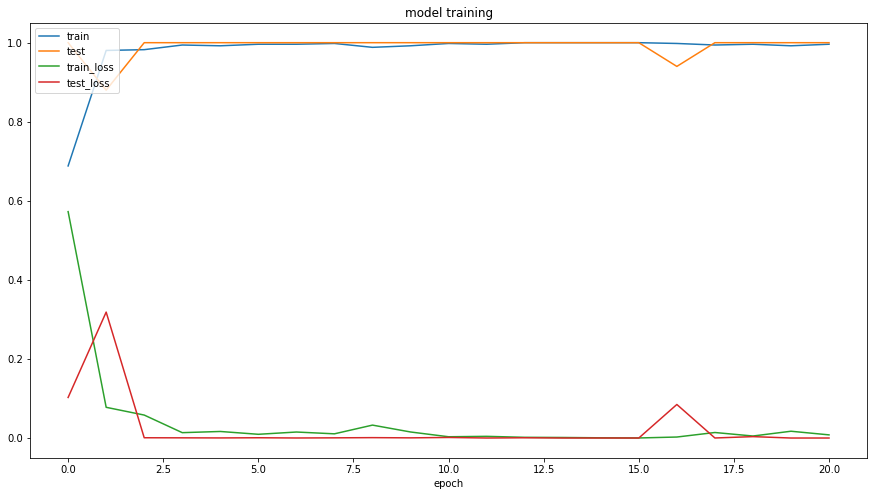

In [282]:
# Mostrar resultado de entrenamiento
plt.subplots(1, 1, figsize = (15, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model training')
plt.xlabel('epoch')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'train_loss', 'test_loss'], loc='upper left')
plt.show()

Pareciera ser que el modelo tiene un desempeño ligeramente peor al del modelo 4. Por esta razón se realizará una evaluación con el set de validación para elegir el mejor modelo.

In [283]:
print(model1.evaluate(validation))
print(model2.evaluate(validation))
print(model3.evaluate(validation))
print(model4.evaluate(validation))
print(model5.evaluate(validation))

2/2 [==============================] - 0s 20ms/step - loss: 0.0533 - accuracy: 0.7400
[0.05326465144753456, 0.7400000095367432]
2/2 [==============================] - 0s 21ms/step - loss: 0.0413 - accuracy: 0.5200
[0.04125455766916275, 0.5199999809265137]
2/2 [==============================] - 0s 22ms/step - loss: 0.5000 - accuracy: 0.5000
[0.5, 0.5]
2/2 [==============================] - 0s 23ms/step - loss: 0.0052 - accuracy: 1.0000
[0.005164527799934149, 1.0]
2/2 [==============================] - 0s 23ms/step - loss: 6.7931e-04 - accuracy: 1.0000
[0.0006793148932047188, 1.0]


Observando la evaluación de los modelos con el set de validación, se observa que el modelo 5 es el mejor.

## Evaluación

Utilizando el modelo 4 se realizarán predicciones con un set de imágenes variadas.

In [295]:
predictions = model5.predict(evaluation)
model5.evaluate(evaluation)

4/4 [==============================] - 0s 20ms/step - loss: 1.0476 - accuracy: 0.9000


[1.047568917274475, 0.8999999761581421]

Se observa una evaluación considerablemente buena, con un *accuracy* alto.

In [296]:
evaluation = evaluation.unbatch()
images = list(evaluation.map(lambda x, y: x))
labels = list(evaluation.map(lambda x, y: y))

In [297]:
images = np.array(images).astype("int64")

In [298]:
preds = []
for pred in predictions:
  if np.where(pred == np.amax(pred))[0][0] == 0:
    preds = np.append(preds, "Bear")
  else:
    preds = np.append(preds, "Panda")
    
cats = []
for cat in labels:
  if cat.numpy() == 0:
    cats = np.append(cats, "Bear")
  else:
    cats = np.append(cats, "Panda")

In [299]:
print(cats)
print(preds)

['Bear' 'Bear' 'Bear' 'Bear' 'Bear' 'Bear' 'Bear' 'Bear' 'Bear' 'Bear'
 'Panda' 'Panda' 'Panda' 'Panda' 'Panda' 'Panda' 'Panda' 'Panda' 'Panda'
 'Panda']
['Bear' 'Bear' 'Panda' 'Bear' 'Bear' 'Bear' 'Bear' 'Panda' 'Bear' 'Bear'
 'Panda' 'Panda' 'Panda' 'Panda' 'Panda' 'Panda' 'Panda' 'Panda' 'Panda'
 'Panda']


Se puede observar qué en las predicciones solo tiene un solo error.

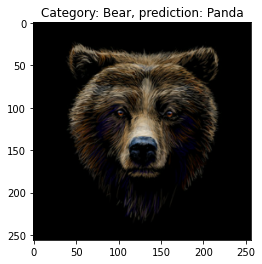

In [300]:
eva = 2
plt.imshow(images[eva])
cat = cats[eva]
pred = preds[eva]

plt.title("Category: " + cat + ", prediction: " + pred)
plt.show()

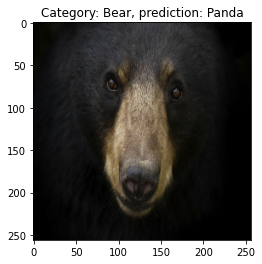

In [301]:
eva = 7
plt.imshow(images[eva])
cat = cats[eva]
pred = preds[eva]

plt.title("Category: " + cat + ", prediction: " + pred)
plt.show()

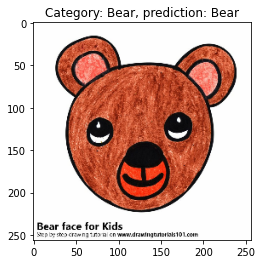

In [291]:
eva = 4
plt.imshow(images[eva])
cat = cats[eva]
pred = preds[eva]

plt.title("Category: " + cat + ", prediction: " + pred)
plt.show()

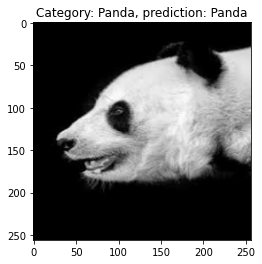

In [292]:
eva = 19
plt.imshow(images[eva])
cat = cats[eva]
pred = preds[eva]

plt.title("Category: " + cat + ", prediction: " + pred)
plt.show()

Se observa que el modelo tiene un desempeño considerablemente bueno. Tiene la capacidad de identificar correctamente osos de pandas aún cuando son dibujos en lugar de imágenes reales. Además, es lo suficientemente general y robusto para identificar correctamente pandas y osos aun cuando están de perfil.

Por supuesto, el modelo no es perfecto, pero considero que tiene un desempeño adecuado y que podría ser utilizado para la clasificación correcta de osos y pandas en distintos contextos.

In [302]:
model4.save("/content/drive/MyDrive/702/MomentoRetroM2/E1/Modelo")